## Amazon Textract Queries

Amazon Textract Queries provides customers the flexibility to easily specify and extract valuable pieces of information that are important for their business process from a document or collection of documents. Customers who know the critical fields they need to extract from a document, can pass that context to Textract Queries. 

Providing this context means, Textract can focus on the parts of the document that are most important and take advantage of visual, spatial, and textual cues to extract the data requested. With this additional context, customers no longer need to lookout for an exact match field name, or maintain a list of synonyms across documents. 

With Textract Queries, customers can extract with high accuracy regardless of the how the data is laid out in a document structure such as forms, tables, and checkboxes, or housed within nested sections within a document.
 
By using Textract Queries, customers do not write additional post-processing code to figure out which key-value or table value corresponds to what they need, or require to train and integrate with custom models to detect the implied fields such as name, and address within the documents or require manual inputs to infer the extracted data. With Textract Queries’s flexibility to specify and extract valuable pieces of information that are important for various stages in a business process, customers can scale up their workflows, drive automation, and efficiencies in the underlying business processes more quickly and easily. 

### Setup

Install boto3 and the textract-response-parser.

This version of the amazon-textract-response-parser is not published as the Textract Query feature is not publicly available yet, but instead included as a wheel locally.

In [1]:
!python -m pip -q install boto3 amazon_textract_response_parser-0.1.21-py2.py3-none-any.whl

In [4]:
image_filename = "paystub.png"

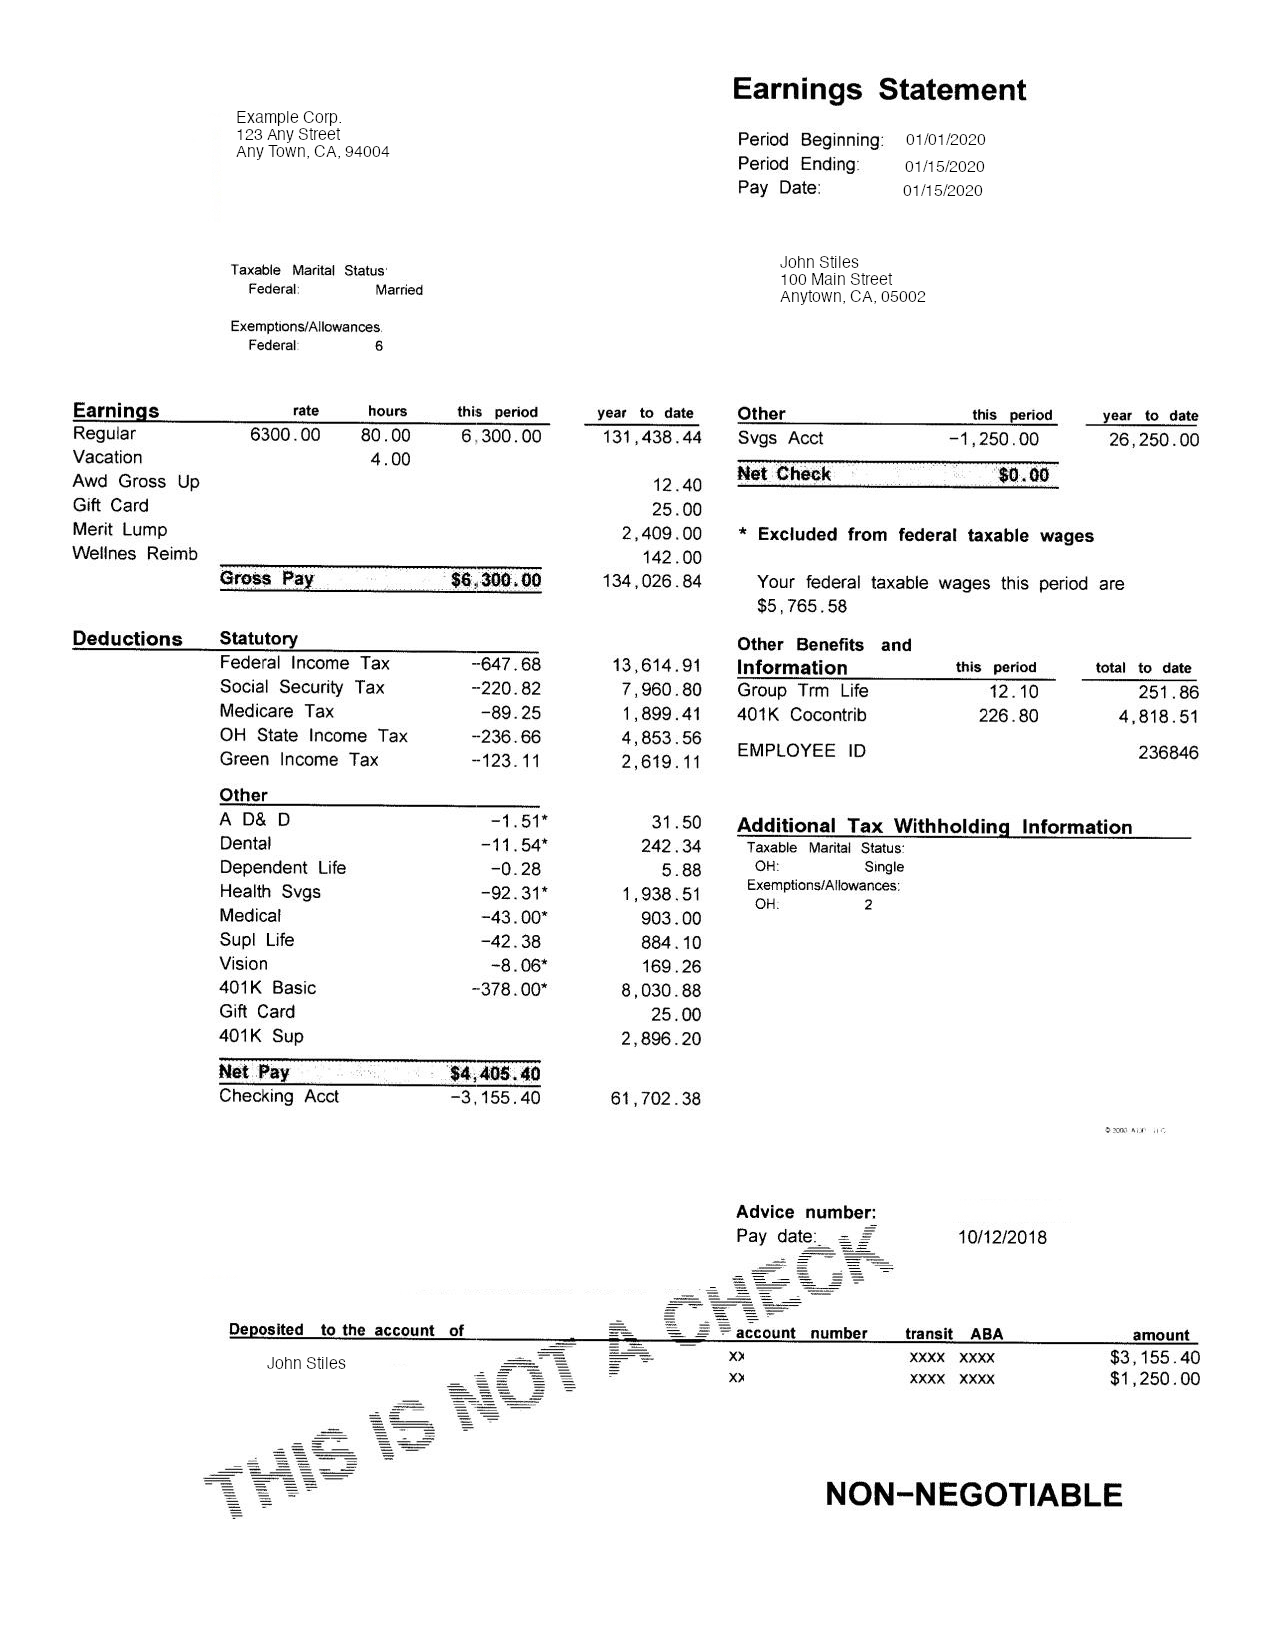

In [5]:
from IPython.display import Image
Image(filename=image_filename)

In [6]:
import boto3
import json

#create a Textract Client
textract = boto3.client('textract')

In [7]:
response = None
with open(image_filename, 'rb') as document:
    imageBytes = bytearray(document.read())

    # Call Textract
    response = textract.analyze_document(
        Document={'Bytes': imageBytes},
        FeatureTypes=["QUERIES"],
        QueriesConfig={
            "Queries": [{
                "Text": "What is the year to date gross pay",
                "Alias": "PAYSTUB_YTD_GROSS"
            },
            {
                "Text": "What is the current gross pay?",
                "Alias": "PAYSTUB_CURRENT_GROSS"
            }]
        })

    print(json.dumps(response))


{"DocumentMetadata": {"Pages": 1}, "Blocks": [{"BlockType": "PAGE", "Geometry": {"BoundingBox": {"Width": 0.9996078610420227, "Height": 1.0, "Left": 0.0, "Top": 0.0}, "Polygon": [{"X": 0.0, "Y": 0.0}, {"X": 0.9996078610420227, "Y": 9.463179803411622e-17}, {"X": 0.9996078610420227, "Y": 1.0}, {"X": 0.0, "Y": 1.0}]}, "Id": "2f9c3d80-99d3-41b4-b5a7-caa0a60f3dde", "Relationships": [{"Type": "CHILD", "Ids": ["3d7ab95b-cf5c-42e1-8bc5-109a25d70dbe", "6741529f-3b88-4ef9-b143-70e525436414", "0f8bd17e-d5cd-48ab-8363-271b3703398b", "71354a88-def2-4048-ad24-8ae3282270d7", "5b15a335-9fce-4e54-bc74-b9102ae9f64b", "cab61aab-4f73-40e5-859f-dee17dba2b84", "5540a4dc-6d6f-4533-89b4-9c49aa148519", "6630f22c-5bda-4a7e-a6b5-36e370fcb910", "b0633507-2813-44ec-80b0-82cd324079cb", "c43d0ee0-2aec-40c3-ae29-1fc4a52aff7a", "bd7ac2f8-3758-46c6-9aeb-b19155be5ec4", "f14d8030-320e-4f8e-93ee-9459573dbd23", "d8bb3aa0-70d4-4dfb-a995-8d2cb8c782be", "6af00c9f-99e8-4275-b4b7-4f6b06ce2949", "ba70e22b-eecf-4f6f-b6ff-d006f725

## Parsing the response

The amazon-textract-response-parser library makes it easy to extract the answers to the questions from the Textract JSON schema

In [8]:
import trp.trp2 as t2

In [9]:
d = t2.TDocumentSchema().load(response)
page = d.pages[0]
# get_query_answers returns a list of [query, alias, answer]
query_answers = d.get_query_answers(page=page)
for x in query_answers:
    print(f"{image_filename},{x[1]},{x[2]}")

paystub.png,PAYSTUB_YTD_GROSS,134,026.84
paystub.png,PAYSTUB_CURRENT_GROSS,$6,300.00


Tabulate allows for visualization of the response

In [10]:
!python -m pip install tabulate

In [11]:
from tabulate import tabulate
print(tabulate(query_answers, tablefmt="github"))

|------------------------------------|-----------------------|------------|
| What is the year to date gross pay | PAYSTUB_YTD_GROSS     | 134,026.84 |
| What is the current gross pay?     | PAYSTUB_CURRENT_GROSS | $6,300.00  |


## Example using question from a CSV file

We can use a CSV file to define the questions and aliases, which is easier to maintain and version compared to having them all in the Python code

In [12]:
!cat "paystub-questions_subset.csv"

In [13]:
queries_csv = "paystub-questions_subset.csv"

In [14]:
# assumes an alias for each question
import csv
queries = list()
with open(queries_csv, mode='r', encoding='utf-8-sig') as queries_csv_file:
    reader = csv.reader(queries_csv_file)
    for row in reader:
        queries.append({"Text": row[0].strip(), "Alias": row[1] })

In [15]:
response = None
with open(image_filename, 'rb') as document:
    image_bytes = bytearray(document.read())

    # Call Textract
    response = textract.analyze_document(
        Document={'Bytes': image_bytes},
        FeatureTypes=["QUERIES"],
        QueriesConfig={
            "Queries": queries
        })

    print(json.dumps(response))

{"DocumentMetadata": {"Pages": 1}, "Blocks": [{"BlockType": "PAGE", "Geometry": {"BoundingBox": {"Width": 0.9996078610420227, "Height": 1.0, "Left": 0.0, "Top": 0.0}, "Polygon": [{"X": 0.0, "Y": 0.0}, {"X": 0.9996078610420227, "Y": 9.463179803411622e-17}, {"X": 0.9996078610420227, "Y": 1.0}, {"X": 0.0, "Y": 1.0}]}, "Id": "d85cfe0e-77b8-4a58-b220-9c7d6f142c6c", "Relationships": [{"Type": "CHILD", "Ids": ["f1d6bcf5-977f-4777-bbd4-89664b72ed60", "3d6fe0bb-d135-4e5c-b5b4-9e32ee8f69e2", "b7cfe06a-e95d-4840-bc66-289897dde110", "6980d7f7-fadf-4621-8e40-0ce6cf535ff8", "c871a272-e75b-41d8-9f94-f735095c17a2", "c77ca366-cbaf-49aa-8b25-15fdb7c807d6", "26183664-b02e-473e-a0c2-4edaff7a53cc", "3845d552-aece-4d70-98b4-2d3625860c59", "498c9a0a-6314-4116-997e-c6d1d19b5565", "6d6eaa2e-3891-4dd4-8feb-3f9dfa1faa7f", "444f736d-a386-4dd0-bdbb-62354b42f7df", "d8c69fe0-e1c8-46dd-be79-ddcd06bb3421", "1bcc9c4b-7c0d-420d-ae5b-4b069096a460", "88ea67bc-1d57-4697-9e3e-22afc7f649a5", "b931b007-691a-4c19-af13-ae143f99

In [16]:
d = t2.TDocumentSchema().load(response)
page = d.pages[0]
# get_query_answers returns a list of [query, alias, answer]
query_answers = d.get_query_answers(page=page)
for x in query_answers:
    print(f"{image_filename},{x[1]},{x[2]}")

paystub.png,PAYSTUB_EMPLOYEE_ADDRESS,100 Main Street Anytown, CA, 05002
paystub.png,PAYSTUB_YTD_GROSS,134,026.84
paystub.png,PAYSTUB_YTD_NET,
paystub.png,PAYSTUB_EMPLOYEE_NAME,John Stiles
paystub.png,PAYSTUB_FEDERAL_FILING,Married
paystub.png,PAYSTUB_CURRENT_NET,$4,405.40
paystub.png,PAYSTUB_CURRENT_GROSS,$6,300.00
paystub.png,PAYSTUB_END_DATE,01/15/2020
paystub.png,PAYSTUB_WARNINGS,
paystub.png,PAYSTUB_PAY_DATE,01/15/2020
paystub.png,PAYSTUB_EMPLOYER_NAME,Example Corp.
paystub.png,PAYSTUB_EMPLOYER_ADDRESS,123 Any Street Any Town, CA, 94004
paystub.png,PAYSTUB_MESSAGES,
paystub.png,PAYSTUB_STATE_FILING,Single
paystub.png,PAYSTUB_START_DATE,01/01/2020


Here we print out the questions and answers in a CSV format

In [17]:
from io import StringIO
import csv
csv_output = StringIO()
csv_writer = csv.writer(csv_output, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
for qa in query_answers:
    csv_writer.writerow([image_filename, qa[1], qa[2]])
print(csv_output.getvalue())


paystub.png,PAYSTUB_EMPLOYEE_ADDRESS,"100 Main Street Anytown, CA, 05002"
paystub.png,PAYSTUB_YTD_GROSS,"134,026.84"
paystub.png,PAYSTUB_YTD_NET,
paystub.png,PAYSTUB_EMPLOYEE_NAME,John Stiles
paystub.png,PAYSTUB_FEDERAL_FILING,Married
paystub.png,PAYSTUB_CURRENT_NET,"$4,405.40"
paystub.png,PAYSTUB_CURRENT_GROSS,"$6,300.00"
paystub.png,PAYSTUB_END_DATE,01/15/2020
paystub.png,PAYSTUB_WARNINGS,
paystub.png,PAYSTUB_PAY_DATE,01/15/2020
paystub.png,PAYSTUB_EMPLOYER_NAME,Example Corp.
paystub.png,PAYSTUB_EMPLOYER_ADDRESS,"123 Any Street Any Town, CA, 94004"
paystub.png,PAYSTUB_MESSAGES,
paystub.png,PAYSTUB_STATE_FILING,Single
paystub.png,PAYSTUB_START_DATE,01/01/2020



### Sequentially parsing blocks of 25 questions

In [18]:
!python -m pip install -q tqdm

In [19]:
from tqdm import tqdm

In [20]:
# assumes an alias for each question
queries_csv = "paystub-questions_full.csv"
queries = list()
with open(queries_csv, mode='r', encoding='utf-8-sig') as queries_csv_file:
    reader = csv.reader(queries_csv_file)
    for row in reader:
        queries.append({"Text": row[0].strip(), "Alias": row[1] })

In [21]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [22]:
queries_chunks = list(chunks(queries, 15))

In [23]:
response = None
query_answers = list()
for queries_chunk in tqdm(queries_chunks):
    with open(image_filename, 'rb') as document:
        image_bytes = bytearray(document.read())

        # Call Textract
        response = textract.analyze_document(
            Document={'Bytes': image_bytes},
            FeatureTypes=["QUERIES"],
            QueriesConfig={
                "Queries": queries_chunk
            })
        
        d = t2.TDocumentSchema().load(response)
        page = d.pages[0]
        # get_query_answers returns a list of [query, alias, answer]
        query_answers.extend(d.get_query_answers(page=page))



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.93s/it]


In [24]:
print(tabulate([[x[1],x[2]] for x in query_answers], tablefmt="github"))

|-------------------------------|------------------------------------|
| PAYSTUB_EMPLOYEE_NAME         | John Stiles                        |
| PAYSTUB_EMPLOYER_NAME         | Example Corp.                      |
| PAYSTUB_CURRENT_GROSS         | $6,300.00                          |
| PAYSTUB_FEDERAL_FILING        | Married                            |
| PAYSTUB_END_DATE              | 01/15/2020                         |
| PAYSTUB_CURRENT_NET           | $4,405.40                          |
| PAYSTUB_MESSAGES              |                                    |
| PAYSTUB_WARNINGS              |                                    |
| PAYSTUB_START_DATE            | 01/01/2020                         |
| PAYSTUB_EMPLOYER_ADDRESS      | 123 Any Street Any Town, CA, 94004 |
| PAYSTUB_STATE_FILING          | Single                             |
| PAYSTUB_YTD_GROSS             | 134,026.84                         |
| PAYSTUB_PAY_DATE              | 01/15/2020                         |
| PAYS

In [25]:
from io import StringIO
import csv
csv_output = StringIO()
csv_writer = csv.writer(csv_output, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
for qa in query_answers:
    csv_writer.writerow([qa[1], qa[2]])
print(csv_output.getvalue())


PAYSTUB_EMPLOYEE_NAME,John Stiles
PAYSTUB_EMPLOYER_NAME,Example Corp.
PAYSTUB_CURRENT_GROSS,"$6,300.00"
PAYSTUB_FEDERAL_FILING,Married
PAYSTUB_END_DATE,01/15/2020
PAYSTUB_CURRENT_NET,"$4,405.40"
PAYSTUB_MESSAGES,
PAYSTUB_WARNINGS,
PAYSTUB_START_DATE,01/01/2020
PAYSTUB_EMPLOYER_ADDRESS,"123 Any Street Any Town, CA, 94004"
PAYSTUB_STATE_FILING,Single
PAYSTUB_YTD_GROSS,"134,026.84"
PAYSTUB_PAY_DATE,01/15/2020
PAYSTUB_YTD_NET,
PAYSTUB_EMPLOYEE_ADDRESS,"100 Main Street Anytown, CA, 05002"
PAYSTUB_YTD_GARNISHMENT,
PAYSTUB_NOTES,
PAYSTUB_REGULAR_HOURS_RATE,6300.00
PAYSTUB_CURRENT_GARNISHMENT,
PAYSTUB_REGULAR_PAY,"6,300.00"
PAYSTUB_HOLIDAY_HOURS_RATE,
PAYSTUB_YTD_CHILD_SUPPORT,
PAYSTUB_YTD_PAY,"131,438.44"
PAYSTUB_CURRENT_CHILD_SUPPORT,
PAYSTUB_CONTACT,

